In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import json
from tensorflow_addons.callbacks import TQDMProgressBar
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm

In [2]:
def history_plot(*args, metric='loss'):
    if len(args) > 1:
        sum_list = []
        for x in args:
            sum_list += x.history[metric]
        val_sum_list = []
        for x in args:
            val_sum_list += x.history['val_' + metric]
        plt.plot(sum_list)
        plt.plot(val_sum_list)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    else:
        history = args[0]
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

In [3]:
def to_one_hot_drop(comp_list):
    X_out = np.zeros((len(comp_list)*5, 745))
    y_out = np.zeros((len(comp_list)*5, 149))
    for i, x in tqdm(enumerate(comp_list)):
        array = label_binarize(x, classes=range(149)).flatten()
        for drop_i in range(5):
            y_out[i*5 + drop_i] = array[drop_i*149:(drop_i+1)*149]
            X_out[i*5 + drop_i] = array
            X_out[i*5 + drop_i, drop_i*149:(drop_i+1)*149] = 0
    return X_out, y_out

In [4]:
def get_top_5_ch(array):
    return [champion_index[np.argmax(sub_array)] for sub_array in np.split(array, 5)]

In [5]:
def get_top_5(array):
    return [np.argmax(sub_array) for sub_array in np.split(array, 5)]

In [6]:
def model_eval(test, test_hat):
    test_id = get_top_5(test)
    print('Test composition: '+str(get_top_5_ch(test)))
    print('Predicted composition: '+str(get_top_5_ch(test_hat)))

    error = [np.argwhere(np.sort(sub_array)[::-1] == sub_array[test_id[i]])[0][0] for i, sub_array in enumerate(np.split(test_hat, 5))]
    print('Predicted rank of test champions: '+str(error))

In [7]:
def rank_eval(y_test, y_test_hat):
    y_hat_rank = [np.argwhere(np.sort(y_test_hat[i])[::-1] == y_test_hat[i,np.argmax(y_test[i])])[0][0] for i in range(len(y_test))]

    print('Average prediction rank: ' + str(np.mean(y_hat_rank)))

    print('No. of correct predictions: ' + str(y_hat_rank.count(0)))

In [22]:
def rank(y_test,y_test_hat):
    return np.argwhere(np.sort(y_test_hat)[::-1] == y_test_hat[np.argmax(y_test)])[0][0]

In [9]:
champion_index = list(pd.read_csv('processed_data/chamion_index.csv', index_col=0).values.flatten())

champion_dict = {y:i for i,y in enumerate(champion_index)}

df = pd.read_csv('processed_data/balanced_class_df.csv')

df.champions = df.champions.apply(lambda x: ast.literal_eval(x))

df['champion_ids'] = df.champions.apply(lambda x: [champion_dict[y] for y in x])

df = df.drop_duplicates(subset=['team', 'id', 'win']).copy()

In [20]:
df_champ_expanded = pd.DataFrame.from_records(df.champions.values, columns=['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'SUPPORT'])

df_champ_counts = df_champ_expanded.apply(lambda x :x.value_counts())

In [11]:
X, y = to_one_hot_drop(list(df.champion_ids))

In [12]:
X.shape

(203385, 745)

In [13]:
y.shape

(203385, 149)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)

In [16]:
CBoW = tf.keras.Sequential()

CBoW.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(745,)))
CBoW.add(tf.keras.layers.Dense(149, activation='softmax'))

In [26]:
CBoW.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['mae', 'mse'])

In [27]:
tqdm_callback = TQDMProgressBar(show_epoch_progress=False)

In [28]:
CBoW.evaluate(X_test, y_test)

636/636 [==============================] - 0s 580us/step - loss: 0.0403 - mae: 0.0133 - mse: 0.0067


[0.04027830809354782, 0.013332775793969631, 0.006666446104645729]

In [37]:
history2 = CBoW.fit(X_train, y_train,
                    epochs=30000,
                    batch_size=256,
                    shuffle=True,
                    verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[tqdm_callback])

In [39]:
CBoW.evaluate(X_test, y_test)

636/636 [==============================] - 0s 609us/step - loss: 0.0390 - mae: 0.0133 - mse: 0.0066


[0.038966331630945206, 0.013297338038682938, 0.00664807204157114]

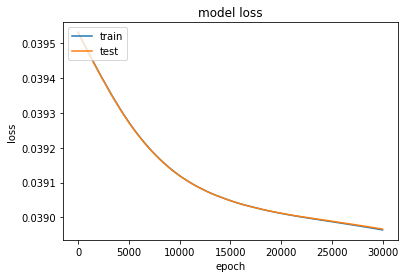

In [38]:
history_plot(history2)

In [40]:
y_test_hat = CBoW.predict(X_test)

In [41]:
rank_eval(y_test, y_test_hat)

Average prediction rank: 48.257682285264764
No. of correct predictions: 447


In [33]:
CBoW.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                11936     
_________________________________________________________________
dense_1 (Dense)              (None, 149)               2533      
Total params: 14,469
Trainable params: 14,469
Non-trainable params: 0
_________________________________________________________________
